#A method to use an IMU to balance poppy with movements of his arms

In [1]:
from poppy.creatures import PoppyHumanoid

poppy = PoppyHumanoid(simulator='vrep',scene='poppy_humanoid_add_force.ttt')

%pylab inline
import time

Populating the interactive namespace from numpy and matplotlib


Prepared poppy for experiments

In [2]:
poppy.head_y.goto_position(0, 4, wait=False)
poppy.r_shoulder_y.goto_position(0, 4, wait=False)
poppy.l_shoulder_y.goto_position(0, 4, wait=True)
poppy.l_shoulder_x.goto_position(20, 4, wait=False)
poppy.r_shoulder_x.goto_position(-20, 4, wait=True)

Track the head like an IMU could do. On the next graph, you can see the pushing force every two minutes on the chest.

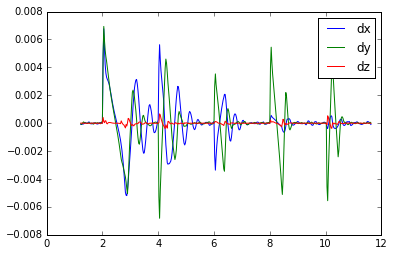

In [7]:
list_pos_x = []
list_pos_y = []
list_pos_z = []
t= []

pos = poppy.get_object_position('head_visual')
pos_x=pos[0]
pos_y=pos[1]
pos_z=pos[2]

t0 = time.time()

while time.time() - t0 < 30:
    pos = poppy.get_object_position('head_visual')
    
    
    if pos_x != pos[0]:
        decalage_x=pos[0]-pos_x
        decalage_y=pos[1]-pos_y
        decalage_z=pos[2]-pos_z
    
    

        list_pos_x.append(decalage_x)
        list_pos_y.append(decalage_y)
        list_pos_z.append(decalage_z)
    
        pos_x = pos[0]
        pos_y = pos[1]
        pos_z = pos[2]
    
        t.append(poppy.current_simulation_time)
    
    time.sleep(0.01)
    
plot(t, list_pos_x)
plot(t, list_pos_y)
plot(t, list_pos_z)


legend(('dx', 'dy','dz'))

Changing the reference frame from absolute to a frame relative to poppy (if you want to know more on matrix of rotation, you have [this tutorial](http://nbviewer.ipython.org/github/jjehl/poppy_balance/blob/master/tutorial_rotation_matrix.ipynb). Choosing the frame oriented by visual chest. The graph shows the same movement but in the relative frame and the arms try to decrease the ocillation by balancing the movement in the opposite direction. 

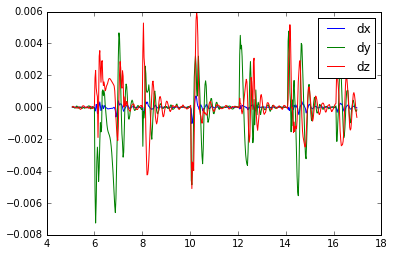

In [10]:
def rotate_matrix(a,b,g):
    Rx = np.mat([[1,0,0], [0,cos(a),-sin(a)], [0,sin(a),cos(a)]])
    Ry = np.mat([[cos(b),0,sin(b)], [0,1,0], [-sin(b),0,cos(b)]])
    Rz = np.mat([[cos(g),-sin(g),0], [sin(g),cos(g),0], [0,0,1]])
    Rot = Rz*Ry*Rx
    return Rot

list_pos_x = []
list_pos_y = []
list_pos_z = []
t= []

pos0 = np.mat(poppy.get_object_position('head_visual')).transpose()
t0 = time.time()
time.sleep(0.01)

while time.time() - t0 < 60:
    pos1 = np.mat(poppy.get_object_position('head_visual')).transpose()
    if any(pos1 != pos0):
        d_pos = pos1-pos0
        
        #make a rotation to d_pos to transpose the movement in a relative frame (frame of chest_visual)
        orient_chest = poppy.get_object_orientation('chest_visual')
        Rot=rotate_matrix(-orient_chest[0],-orient_chest[1],-orient_chest[2])
        d_pos=Rot*d_pos
        
        #balance the movement with an opposite movement of the arm
        #le terme instantanée doit être ajouté à un terme intégré sur les 10 derniers mouvements
        poppy.r_shoulder_y.goal_position = d_pos[1]*2000
        poppy.l_shoulder_y.goal_position = d_pos[1]*2000
        poppy.r_shoulder_x.goal_position = -20-d_pos[2]*2000
        poppy.l_shoulder_x.goal_position = 20-d_pos[2]*2000
        
        list_pos_x.append(float(d_pos[0]))
        list_pos_y.append(float(d_pos[1]))
        list_pos_z.append(float(d_pos[2]))
        t.append(poppy.current_simulation_time)
        pos0 = pos1
    time.sleep(0.01)

  
plot(t, list_pos_x)
plot(t, list_pos_y)
plot(t, list_pos_z)
legend(('dx', 'dy','dz'))

The balance use only the speed of the movement (i.e the movement of the arm is only proportional to the speed of the move of the head. It could be better to use also the acceleration and the position (integration of speed). So to be continued...

One test more with the possibility to react in function of the position and the acceleration.

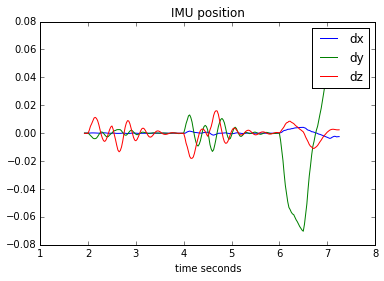

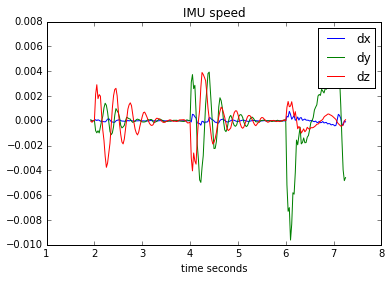

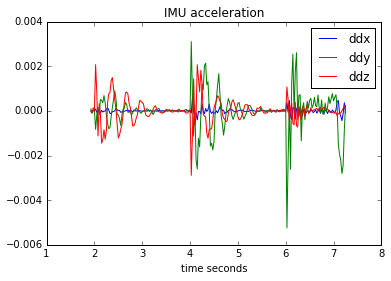

In [3]:
# choose the coefficient you want to apply to speed, position and acceleration. (P S A)
P = 200
S = 2000
A = 2000


class IMU:
    def __init__(self,nb_record=10):
        self.record_pos=[]
        i=0
        while i<nb_record:
            self.record_pos.insert(0,0)
            i+=1
            
    def add_pos(self,d_pos):
        size = len(self.record_pos)
        self.record_pos.insert(0,d_pos)
        del self.record_pos[size]
        
    def speed(self):
        return self.record_pos[0]
    
    def acceleration(self):
        return self.record_pos[0]-self.record_pos[1]
    
    def position(self):
        integrate = 0
        for i in self.record_pos:
            integrate += i
        return integrate


def rotate_matrix(a,b,g):
    Rx = np.mat([[1,0,0], [0,cos(a),-sin(a)], [0,sin(a),cos(a)]])
    Ry = np.mat([[cos(b),0,sin(b)], [0,1,0], [-sin(b),0,cos(b)]])
    Rz = np.mat([[cos(g),-sin(g),0], [sin(g),cos(g),0], [0,0,1]])
    Rot = Rz*Ry*Rx
    return Rot

list_pos_x = []
list_pos_y = []
list_pos_z = []

list_speed_x = []
list_speed_y = []
list_speed_z = []

list_acceleration_x = []
list_acceleration_y = []
list_acceleration_z = []

t= []

pos0 = np.mat(poppy.get_object_position('head_visual')).transpose()
t0 = time.time()
time.sleep(0.01)

IMU_x = IMU(20)
IMU_y = IMU(20)
IMU_z = IMU(20)

while time.time() - t0 < 15:
    pos1 = np.mat(poppy.get_object_position('head_visual')).transpose()
    if any(pos1 != pos0):
        d_pos = pos1-pos0
        
        #make a rotation to d_pos to transpose the movement in a relative frame (frame of chest_visual)
        orient_chest = poppy.get_object_orientation('chest_visual')
        Rot=rotate_matrix(-orient_chest[0],-orient_chest[1],-orient_chest[2])
        d_pos=Rot*d_pos
        
        # record the speed with the IMU class
        IMU_x.add_pos(float(d_pos[0]))
        IMU_y.add_pos(float(d_pos[1]))
        IMU_z.add_pos(float(d_pos[2]))
        
        #balance the movement with an opposite movement of the arm
        
        poppy.r_shoulder_y.goal_position = IMU_y.speed()*S+IMU_y.position()*P+IMU_y.acceleration()*A
        poppy.l_shoulder_y.goal_position = IMU_y.speed()*S+IMU_y.position()*P+IMU_y.acceleration()*A
        poppy.r_shoulder_x.goal_position = -20-IMU_z.speed()*S-IMU_z.position()*P-IMU_z.acceleration()*A
        poppy.l_shoulder_x.goal_position = 20-IMU_z.speed()*S-IMU_z.position()*P-IMU_z.acceleration()*A
        
        
        
        # record for graph
        list_pos_x.append(IMU_x.position())
        list_pos_y.append(IMU_y.position())
        list_pos_z.append(IMU_z.position())
        
        list_speed_x.append(IMU_x.speed())
        list_speed_y.append(IMU_y.speed())
        list_speed_z.append(IMU_z.speed())
        
        list_acceleration_x.append(IMU_x.acceleration())
        list_acceleration_y.append(IMU_y.acceleration())
        list_acceleration_z.append(IMU_z.acceleration())
        
        t.append(poppy.current_simulation_time)
        
        pos0 = pos1
    time.sleep(0.01)


figure(1)
plot(t, list_pos_x)
plot(t, list_pos_y)
plot(t, list_pos_z)
legend(('dx', 'dy','dz'))
xlabel('time seconds')
title ('IMU position')
    
figure(2)    
plot(t, list_speed_x)
plot(t, list_speed_y)
plot(t, list_speed_z)
legend(('dx', 'dy','dz'))
xlabel('time seconds')
title ('IMU speed')

figure(3)
plot(t, list_acceleration_x)
plot(t, list_acceleration_y)
plot(t, list_acceleration_z)
legend(('ddx', 'ddy','ddz'))
xlabel('time seconds')
title ('IMU acceleration')

What can I say, in conclusion : movement of the arm improve the stability but the movement of the arms have two different opposite effects : moving the gravity center and create an inertial force in the opposite direction of the moving of the gravity center. The inertial force is create during the movement but the move of the gravity center is more durable. 
The question is how to choose the better parameter for P, S, A and even nb_record to optimize the balance of poppy... no answer at the moment...